In [2]:
from typing import *
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
sns.set_context("notebook")

def get_element_dtype(d: Dict[str, Any]) -> str:
     if d["_type"] in ["scalar", "fp", "ieee"]:
          return f"E{d['exponent_bits']}M{d['mantissa_bits']}"
     if d["_type"] == "int":
          return f"E0M{d['bits_']-1}"
     if d["_type"] == "exp":
          return f"EXP{d['exponent_bits']}"
     if d["_type"] == "lut":
          return f"LUT{int(np.log2(len(d['values'])))}[{d['name']}]"
     assert d["_type"] == "linear", d["_type"]
     return get_element_dtype(d["element_format"])

def get_element_dtype_kind(d: Dict[str, Any]) -> str:
     if d["_type"] in ["scalar", "fp"]:
          return "int" if d["exponent_bits"] == 0 else f"E{d['exponent_bits']}"
     if d["_type"] in ["int", "exp"]:
          return "exp"
     if d["_type"] == "lut":
          return d["name"]
     assert d["_type"] == "linear", d["_type"]
     return get_element_dtype_kind(d["element_format"])

def get_element_dtype_bits(d: Dict[str, Any]) -> int:
     if d["_type"] in ["scalar", "fp"]:
          return 1 + d["exponent_bits"] + d["mantissa_bits"]
     if d["_type"] in ["int", "exp"]:
          return d["bits_"]
     if d["_type"] == "lut":
          return int(np.log2(len(d["values"])))
     assert d["_type"] == "linear", d["_type"]
     return get_element_dtype_bits(d["element_format"])

def get_scale_dtype(d: Dict[str, Any]) -> str:
     if d["_type"] == "linear":
          return get_element_dtype(d["scale_format"])

def get_input_group_size(d: Dict[str, Any]) -> Optional[int]:
     if d["_type"] == "linear":
          shapes = d["group_shapes"]
          if len(shapes) == 1:
               if shapes[0][0] == 1:
                    return shapes[0][1]

In [6]:
len(pd.read_json("../../out/sweep_bits.jsonl", lines=True))

100

In [4]:
df = pd.concat([
    pd.read_json("../../out/2023-05-quantisation-4bit/sweep.jsonl", lines=True),
    pd.read_json("../../out/2023-05-quantisation-4-8bit/5-7bit.jsonl", lines=True),
    pd.read_json("../../out/2023-05-quantisation-4-8bit/nonlinear.jsonl", lines=True),
]).reset_index()
df = df.rename(columns={
     c: dict(outcompare="oc", arc_easy="arc", lambada_openai="lam")[c.split(":")[0]] + "_" + c.split(":")[1]
     for c in df.columns
     if ":" in c})

# Derived
df["model"] = df["model"].apply(lambda s: s.split("/")[1])
df["compression"] = df["quantised_bytes"] / (2 * df["parameters"])
df["element_dtype"] = df["format"].apply(get_element_dtype)
df["element_dtype_kind"] = df["format"].apply(get_element_dtype_kind)
df["element_dtype_bits"] = df["format"].apply(get_element_dtype_bits)
df["scale_dtype"] = df["format"].apply(get_scale_dtype)
df["group_size"] = df["format"].apply(get_input_group_size)

# Filters
df = df[df["unembedding_format_name"].apply(lambda s: isinstance(s, str)) | (df["element_dtype"] == "E2M5")]
df = df[df["scale_dtype"] == "E5M10"]
df = df[df["element_dtype"] != "E3M0"]

display(df.sort_values("compression")
        [["model", "compression", "format_name", "oc_entropy_rmse", "oc_exact_match_length", "oc_time"]].head(5))

print("Rows", len(df))

,model,compression,format_name,oc_entropy_rmse,oc_exact_match_length,oc_time
344,pythia-1.4b,0.268931,LUT4[linear]{1.*:E5M10},0.821925,2.240000,1710.757884
23,pythia-1.4b,0.268931,E0M3{1.*:E5M10},0.821020,1.910000,1462.206273
351,pythia-1.4b,0.268931,LUT4[quad]{1.*:E5M10},0.333970,4.686666,1746.686887
337,pythia-1.4b,0.268931,LUT4[NF-approx]{1.*:E5M10},0.303919,5.006667,1726.906344
330,pythia-1.4b,0.268931,LUT4[NF]{1.*:E5M10},0.544632,4.183333,1740.588350


Rows 176


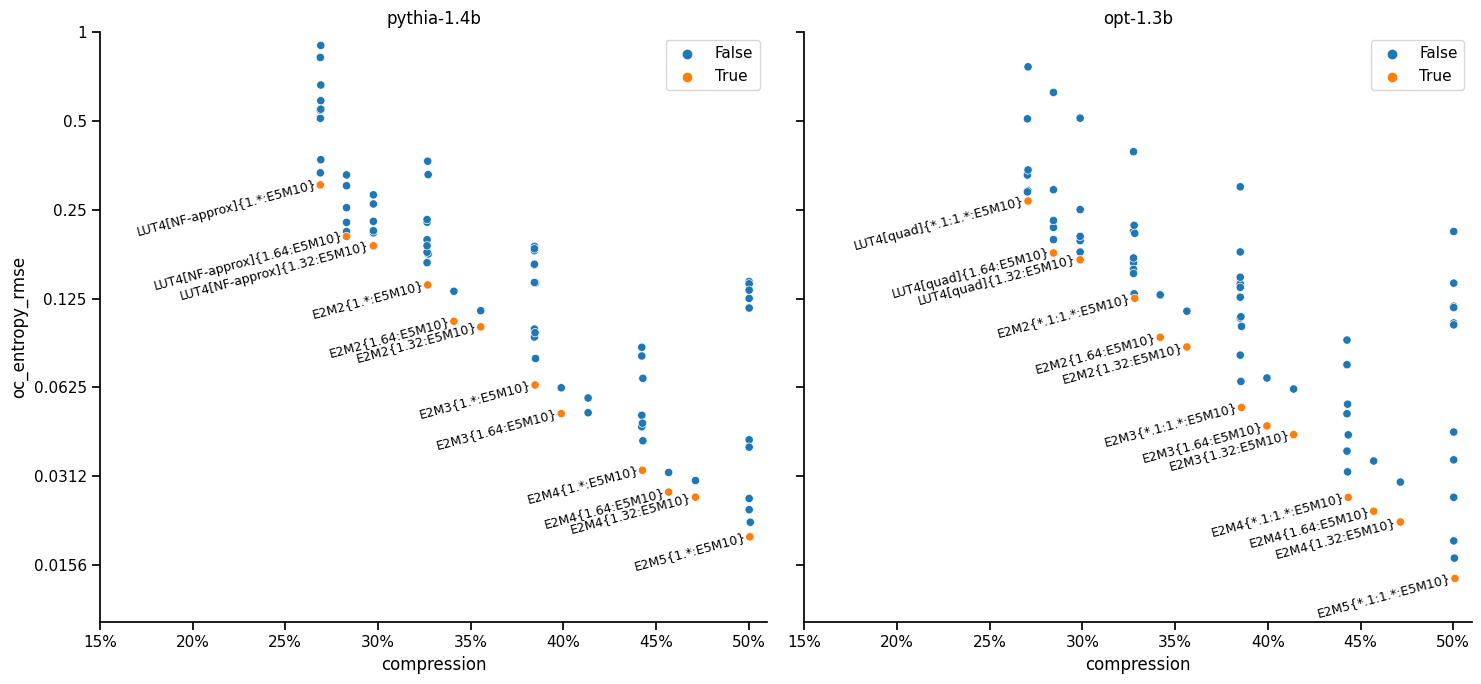

In [33]:
y = "oc_exact_match_length"; sign = -1
y = "oc_entropy_rmse"; sign = 1
for (model, g), ax in zip(df.groupby("model", sort=False), plt.subplots(1, 2, figsize=(15, 7), sharey=True)[1]):
    d = g.assign(optimal=g.apply(lambda s: ~((np.round(100*g["compression"]) <= np.round(100*s["compression"]))
                                             & (g[y]*sign < s[y]*sign)).any(), axis=1))
    sns.scatterplot(data=d, y=y, x="compression", hue="optimal", ax=ax)
    for _, s in d[d.optimal].iterrows():
        ax.annotate(s["format_name"], [s["compression"], s[y]],
                    fontsize=9, ha="right", va="center", xytext=(-3, 0), textcoords="offset points",
                    rotation=sign*15, rotation_mode="anchor")
    ax.set_xlim((0.15, 0.51))
    # ax.set_ylim((2**-6.6, 2**-1))
    ax.set_ylim((0.01, 1))
    ax.set_yscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.3g}"))
    ax.legend_.remove()
    ax.legend(loc="lower right" if sign < 0 else "upper right")
    ax.set_title(model)
plt.tight_layout()
sns.despine()

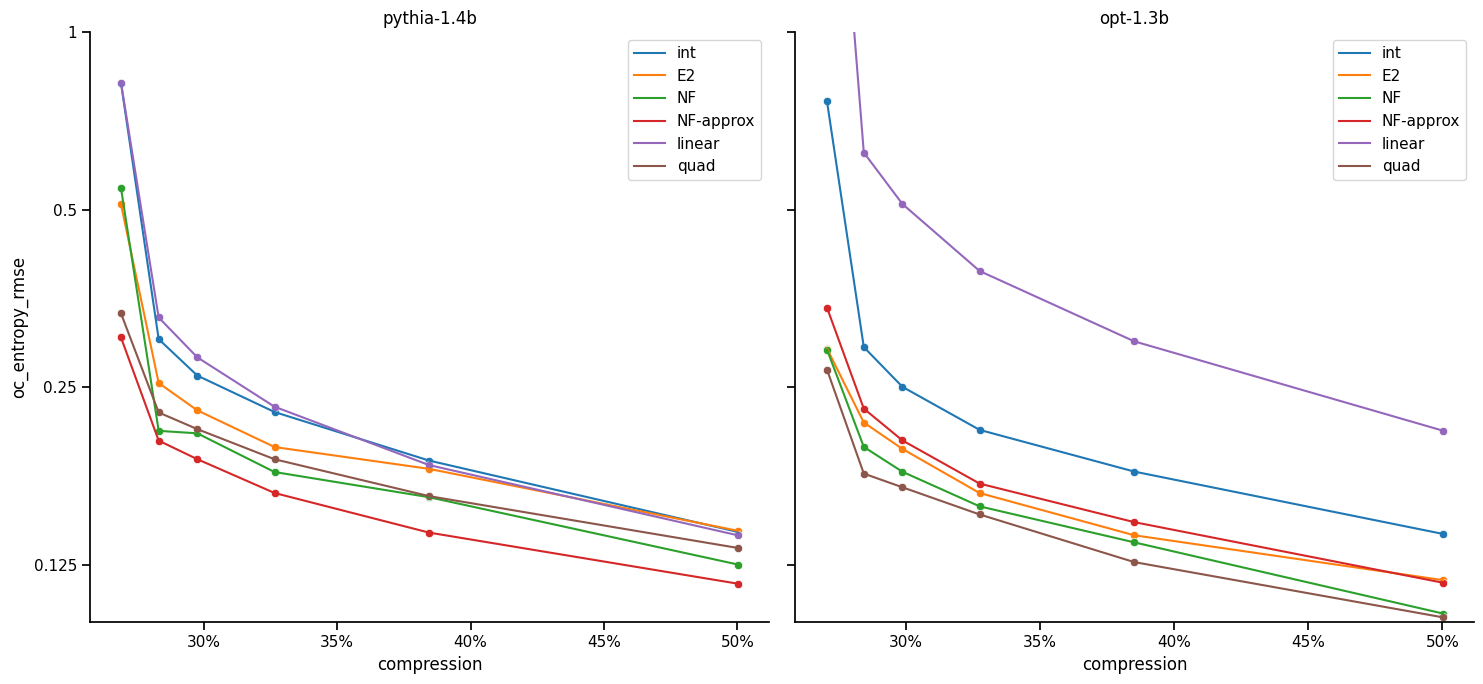

In [32]:
d = (df
     .pipe(lambda d: d[d["element_dtype_bits"]==4])
     .pipe(lambda d: d[d["group_size"]!=2])
)

y = "oc_exact_match_length"; sign = -1
y = "oc_entropy_rmse"; sign = 1
for (model, gg), ax in zip(d.groupby("model", sort=False), plt.subplots(1, 2, figsize=(15, 7), sharey=True)[1]):
    for (kind, g), color in zip(gg.groupby("element_dtype_kind", sort=False), sns.color_palette()):
        d = g[g.apply(lambda s: ~((np.round(100*g["compression"]) <= np.round(100*s["compression"]))
                                   & (g[y]*sign < s[y]*sign)).any(), axis=1)]
        sns.lineplot(data=d, y=y, x="compression", color=color, ax=ax, label=kind)
        sns.scatterplot(data=d, y=y, x="compression", color=color, ax=ax)
    # ax.set_xlim((0.15, 0.51))
    ax.set_ylim((0.1, 1))
    ax.set_yscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.3g}"))
    ax.legend(loc="lower right" if sign < 0 else "upper right")
    ax.set_title(model)
plt.tight_layout()
sns.despine()